In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

# librairies perso
from make_train_test_set import make_train_test_set
from import_data import import_data
from metrics import metrics 
from group_by_clients import group_by_clients
from model import creation_model
from model_by_client import creation_model_by_client

# Dataframe

In [2]:
data = import_data()

In [3]:
def set_up_index(index): 
    index.rename({"Date": "horodate"}, axis = 1, inplace = True)
    index["horodate"] = pd.to_datetime(index["horodate"])
    index.set_index("horodate", inplace = True)
    index = index.asfreq("D")
    index.reset_index(inplace = True)
    index = index.fillna(method = "ffill")
    date = (index["horodate"] >= pd.to_datetime("2021-01-01")) & (index["horodate"] <= pd.to_datetime("2023-01-31"))
    index = index[date]
    index.reset_index(inplace = True)
    index = index[["horodate", "Open"]]
    return index 

In [4]:
CAC = pd.read_csv("../data/^FCHI.csv")
AEX = pd.read_csv("../data/^AEX.csv")
BFX = pd.read_csv("../data/^BFX.csv")
STOXX = pd.read_csv("../data/^STOXX50E.csv")
Airliquide = pd.read_csv("../data/AI.PA.csv")
gasNat = pd.read_csv("../data/EEX.csv").rename({"Ouvert": "Open"}, axis = 1)

CAC = set_up_index(CAC)
AEX = set_up_index(AEX)
BFX = set_up_index(BFX)
STOXX = set_up_index(STOXX)
Airliquide = set_up_index(Airliquide)
gasNat = set_up_index(gasNat)

CAC.rename({"Open": "CAC"}, axis = 1, inplace = True)
AEX.rename({"Open": "AEX"}, axis = 1, inplace = True)
BFX.rename({"Open": "BFX"}, axis = 1, inplace = True)
STOXX.rename({"Open": "STOXX"}, axis = 1, inplace = True)
Airliquide.rename({"Open": "Airliquide"}, axis = 1, inplace = True)
gasNat.rename({"Open": "gasNat"}, axis = 1, inplace = True)

#CAC.rename({"Volume": "CAC"}, axis = 1, inplace = True)
#AEX.rename({"Volume": "AEX"}, axis = 1, inplace = True)
#BFX.rename({"Volume": "BFX"}, axis = 1, inplace = True)
#STOXX.rename({"Volume": "STOXX"}, axis = 1, inplace = True)

In [5]:
# il faut merge avec le tableau principal
data = pd.merge(data, CAC, on = ["horodate"], how = "left")
data = pd.merge(data, AEX, on = ["horodate"], how = "left")
data = pd.merge(data, BFX, on = ["horodate"], how = "left")
data = pd.merge(data, STOXX, on = ["horodate"], how = "left")
data = pd.merge(data, Airliquide, on = ["horodate"], how = "left")
data = pd.merge(data, gasNat, on = ["horodate"], how = "left")
n = data["id_client"].max()
test_data = data[data["horodate"] > pd.to_datetime("2022-08-31")]

# Régression

### Avec le CAC seulement

In [6]:
eval_model_CAC = creation_model(data, ["id_client", "forecasted_consumption", "CAC"], ["real_consumption"])

### Avec le CAC et STOXX 

In [7]:
eval_model_CAC_STOXX = creation_model(data, ["id_client", "forecasted_consumption", "CAC", "STOXX"], ["real_consumption"])

### Avec le CAC, STOXX et Airliquide

In [8]:
eval_model_CAC_STOXX_Airliquide = creation_model(data, ["id_client", "forecasted_consumption", "CAC", "STOXX", "Airliquide"], ["real_consumption"])

### Tous les paramètres 

In [9]:
eval_model_all = creation_model(data, ["id_client", "forecasted_consumption", "CAC", "STOXX", "BFX", "AEX", "Airliquide"], ["real_consumption"])

### Gas nat

In [10]:
eval_model_gasNat = creation_model(data, ["id_client", "forecasted_consumption", "gasNat"], ["real_consumption"])

# Evaluation

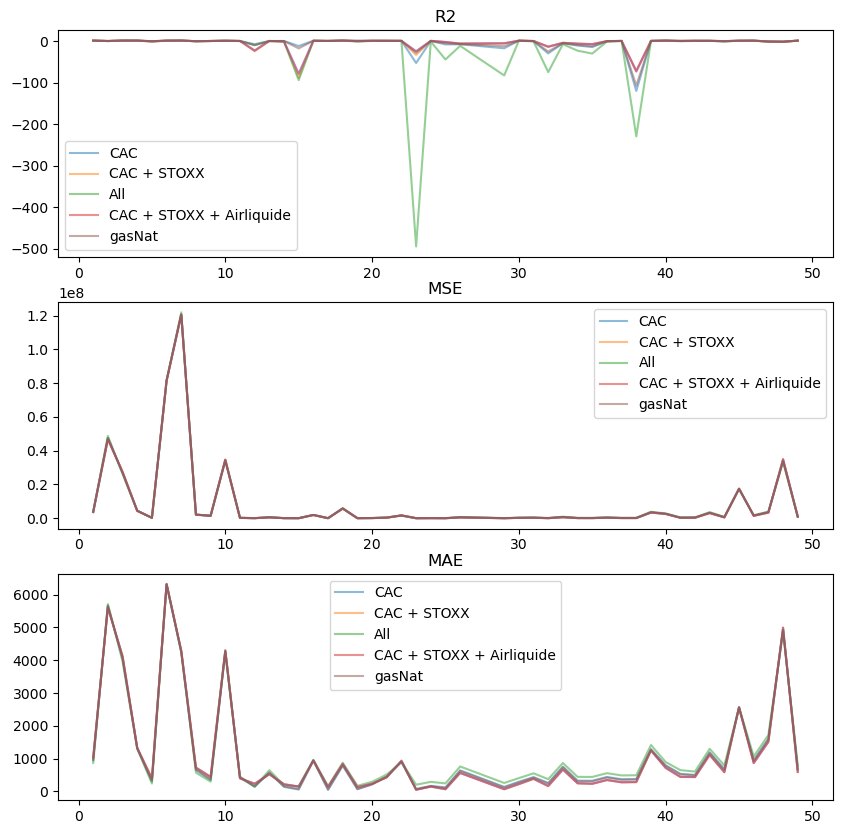

In [11]:
X = list(range(1,n+1))
X2 = list(range(1,n+1))
X2.remove(28)
X2.remove(27)
evalutation_airliquide_model = []
for i in range(n): 
    evalutation_airliquide_model.append(metrics(test_data.groupby("id_client").get_group(i+1)["real_consumption"], test_data.groupby("id_client").get_group(i+1)["prediction"]))

fig, ax = plt.subplots(3, figsize = (10,10))
ax[0].set_title("R2")
ax[1].set_title("MSE")
ax[2].set_title("MAE")
for i in range(3): 
    ax[i].plot(X2, [x[i] for j, x in enumerate(eval_model_CAC) if j not in [27, 28]], label = "CAC", alpha = 0.5)
    ax[i].plot(X2, [x[i] for j, x in enumerate(eval_model_CAC_STOXX) if j not in [27, 28]], label = "CAC + STOXX", alpha = 0.5)
    ax[i].plot(X2, [x[i] for j, x in enumerate(eval_model_all) if j not in [27, 28]], label = "All", alpha = 0.5)
    ax[i].plot(X2, [x[i] for j, x in enumerate(eval_model_CAC_STOXX_Airliquide) if j not in [27, 28]], label = "CAC + STOXX + Airliquide", alpha = 0.5)
    ax[i].plot(X2, [x[i] for j, x in enumerate(eval_model_CAC_STOXX_Airliquide) if j not in [27, 28]], label = "", alpha = 0.5)
    ax[i].plot(X2, [x[i] for j, x in enumerate(eval_model_gasNat) if j not in [27, 28]], label = "gasNat", alpha = 0.5)
    #ax[i].plot(X, [x[i] for x in evalutation_airliquide_model], label = "airliquide")
    ax[i].legend()

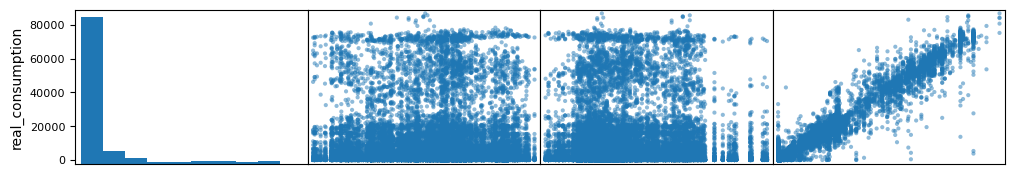

In [12]:
attributes = ["real_consumption","CAC", "gasNat", "forecasted_consumption"]
axes = pd.plotting.scatter_matrix(data[attributes], figsize=(12, 8))

# Masquer les sous-parcelles sauf la première ligne
for i, row in enumerate(axes):
    if i == 0 : 
        for j, subplot in enumerate(row) : 
            subplot.set_xlabel(attributes[j])
    else :
        for subplot in row : 
            subplot.set_visible(False)

# Afficher la matrice de dispersion
plt.show()

# Essai sur un jeu de donné plus clean

In [13]:
clients = data.groupby("id_client")

In [14]:
egal0 = []
for i in range(1,50):
    egal0.append((clients.get_group(i)["real_consumption"] == 0).sum())

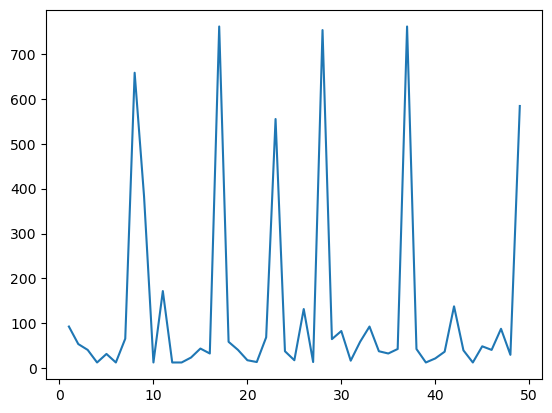

In [15]:
plt.plot(list(range(1,50)), egal0)

In [16]:
(clients.get_group(8)["real_consumption"] == 0).sum()

658

A virer : 38, 49, 28, 17, 23, 9, 8

In [17]:
data = data[~(data["id_client"].isin([8,9, 17, 23, 28, 38 , 49]))]

In [18]:
import pandas as pd
from sklearn.linear_model import LinearRegression
from metrics import metrics


def creation_model(df, xarg, yarg):
    n = df["id_client"].max()
    # train_size = int(len(df.groupby("id_client").get_group(1)) * 0.8)
    # date_lim = df.groupby("id_client").get_group(1)["horodate"][:train_size].iloc[-1]
    train = df[df["horodate"] <= pd.to_datetime("2022-08-31")]
    test = df[df["horodate"] > pd.to_datetime("2022-08-31")]
    X_train = train.copy()[xarg]
    Y_train = train.copy()[yarg]
    X_test = test.copy()[xarg]
    Y_test = test.copy()[yarg]

    # création du model
    model = LinearRegression()
    model.fit(X_train, Y_train)
    y_pred = model.predict(X_test)

    comp = pd.DataFrame(Y_test.copy())
    comp["pred"] = y_pred
    comp["id_client"] = X_test["id_client"]
    evaluation_model = []

    evaluation_model = []
    for i in df["id_client"].unique():
        y = comp.groupby("id_client").get_group(i)["pred"]
        y2 = comp.groupby("id_client").get_group(i)["real_consumption"]
        evaluation_model.append(metrics(y2, y))
    return evaluation_model


In [19]:
eval_model_CAC = creation_model(data, ["id_client", "forecasted_consumption", "CAC"], ["real_consumption"])

In [20]:
eval_model_CAC_STOXX = creation_model(data, ["id_client", "forecasted_consumption", "CAC", "STOXX"], ["real_consumption"])

In [21]:
eval_model_CAC_STOXX_Airliquide = creation_model(data, ["id_client", "forecasted_consumption", "CAC", "STOXX", "Airliquide"], ["real_consumption"])

In [22]:
eval_model_all = creation_model(data, ["id_client", "forecasted_consumption", "CAC", "STOXX", "BFX", "AEX", "Airliquide"], ["real_consumption"])

In [23]:
eval_model_gasNat = creation_model(data, ["id_client", "forecasted_consumption", "gasNat"], ["real_consumption"])

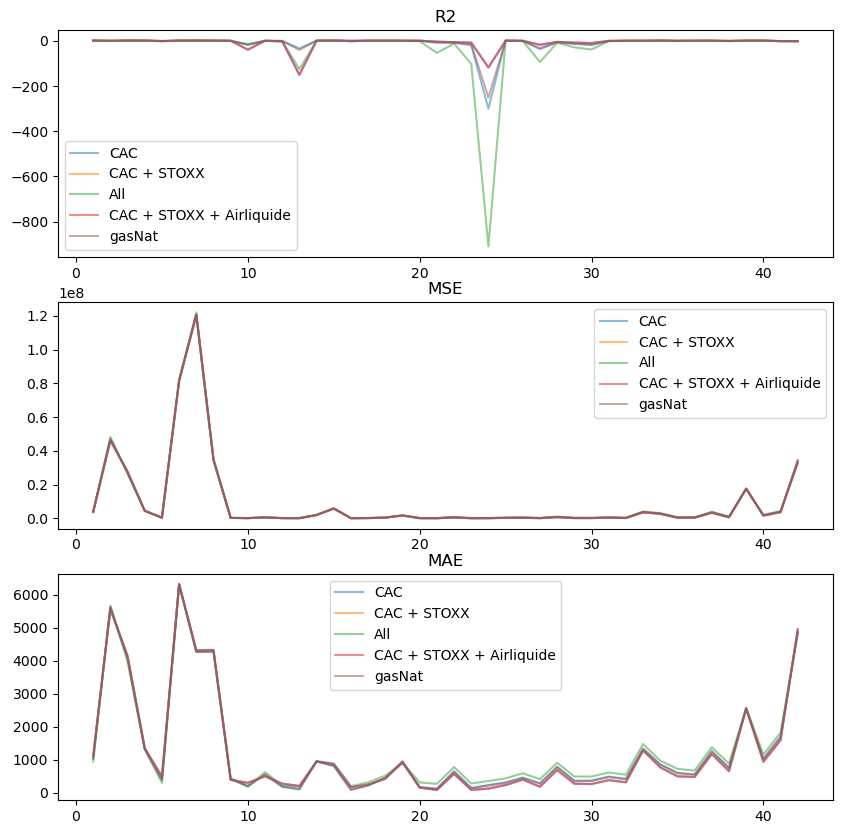

In [24]:
n = len(data["id_client"].unique())
test_data = data[data["horodate"] > pd.to_datetime("2022-08-31")]

X = list(range(1,n+1))

evalutation_airliquide_model = []
for i in data["id_client"].unique(): 
    evalutation_airliquide_model.append(metrics(test_data.groupby("id_client").get_group(i)["real_consumption"], test_data.groupby("id_client").get_group(i)["prediction"]))

fig, ax = plt.subplots(3, figsize = (10,10))
ax[0].set_title("R2")
ax[1].set_title("MSE")
ax[2].set_title("MAE")
for i in range(3): 
    ax[i].plot(X, [x[i] for j, x in enumerate(eval_model_CAC)], label = "CAC", alpha = 0.5)
    ax[i].plot(X, [x[i] for j, x in enumerate(eval_model_CAC_STOXX) ], label = "CAC + STOXX", alpha = 0.5)
    ax[i].plot(X, [x[i] for j, x in enumerate(eval_model_all) ], label = "All", alpha = 0.5)
    ax[i].plot(X, [x[i] for j, x in enumerate(eval_model_CAC_STOXX_Airliquide)], label = "CAC + STOXX + Airliquide", alpha = 0.5)
    ax[i].plot(X, [x[i] for j, x in enumerate(eval_model_CAC_STOXX_Airliquide)], label = "", alpha = 0.5)
    ax[i].plot(X, [x[i] for j, x in enumerate(eval_model_gasNat) ], label = "gasNat", alpha = 0.5)
    #ax[i].plot(X, [x[i] for x in evalutation_airliquide_model], label = "airliquide")
    ax[i].legend()

In [25]:
r2 = lambda lst : sum([x[0] for x in lst])
MSE = lambda lst : sum([x[1] for x in lst])
MAE = lambda lst : sum([x[2] for x in lst])

In [26]:
eval = {"CAC": {"MSE": MSE(eval_model_CAC), "MAE": MAE(eval_model_CAC)}, "CAC + STOXX": {"MSE": MSE(eval_model_CAC_STOXX), "MAE": MAE(eval_model_CAC_STOXX)}, 
       "All": {"MSE": MSE(eval_model_all), "MAE": MAE(eval_model_all)}, "gasNat": {"MSE": MSE(eval_model_gasNat), "MAE": MAE(eval_model_gasNat)}}

In [27]:
pd.DataFrame(eval)

,CAC,CAC + STOXX,All,gasNat
MSE,4.006134e+08,3.995783e+08,4.074716e+08,3.997514e+08
MAE,5.251269e+04,5.153566e+04,5.550374e+04,5.227171e+04


seul le STOXX améliore le modèle. 